In [ ]:
!pip install selfies
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 17.1 MB/s eta 0:00:00


Loading SELFIES from CSV...
Loaded 19996 SELFIES from filtered_dataset.csv.
Vocabulary size: 123
Starting adversarial training (without RL)...
Epoch [5/50] | D Loss: 1.295 | G Adv Loss: 0.667
Epoch [10/50] | D Loss: 1.136 | G Adv Loss: 0.709
Epoch [15/50] | D Loss: 0.911 | G Adv Loss: 0.798
Epoch [20/50] | D Loss: 0.515 | G Adv Loss: 1.029
Epoch [25/50] | D Loss: 0.302 | G Adv Loss: 1.431
Epoch [30/50] | D Loss: 0.321 | G Adv Loss: 2.187
Epoch [35/50] | D Loss: 0.066 | G Adv Loss: 3.143
Epoch [40/50] | D Loss: 0.375 | G Adv Loss: 3.451
Epoch [45/50] | D Loss: 0.042 | G Adv Loss: 3.261
Epoch [50/50] | D Loss: 0.278 | G Adv Loss: 2.761

Training complete!

Generating 100 molecules...

Evaluation of generated molecules:
  Validity:   0.88
  Uniqueness: 1.00
  Diversity:  0.97

Sample of generated SELFIES:
SELFIES: [Br-1][Sm][S@@][#N][=N][\Cl][=N][Br-1][N][/O][Branch2][Sm][/C@@][Cu][O-1][\C@@][/C@@][/S@@+1][\O][Mn][C@][S@@+1][BH0][K+1][=C][Fe][S@@][N@][Fe][Ca+2][S@@][N@+1][131I][I][Sm][/Cl

[17:42:05] Explicit valence for atom # 0 Br, 1, is greater than permitted
[17:42:05] Explicit valence for atom # 3 Br, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 8 Br, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 16 Cl, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 4 Br, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 2 Cl, 4, is greater than permitted
[17:42:05] Explicit valence for atom # 12 Br, 3, is greater than permitted
[17:42:05] Explicit valence for atom # 13 Br, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 14 Cl, 2, is greater than permitted
[17:42:05] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[17:42:05] DEPRECATION WARNING: please use MorganGenerator
[17:42:05] DEPRECATION WARNING: please use Morgan

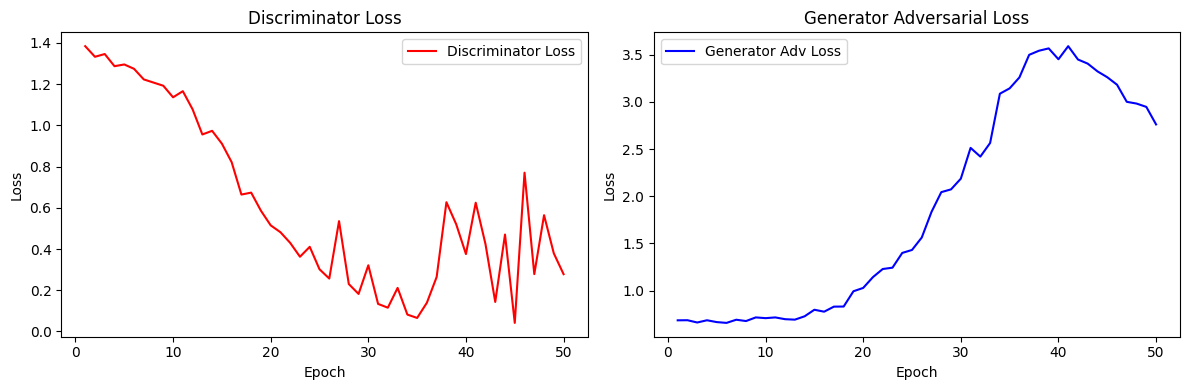

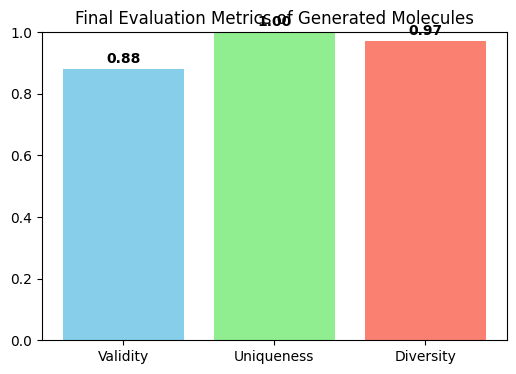

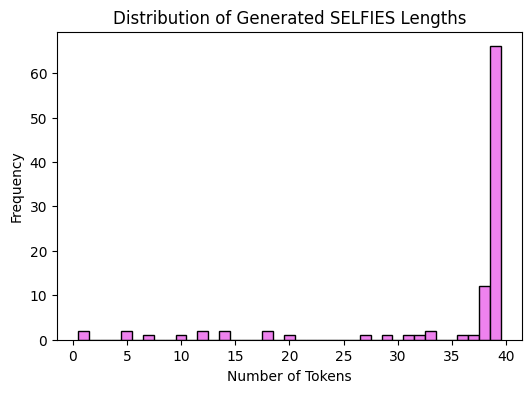

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import selfies  # pip install selfies
import matplotlib.pyplot as plt

###############################################################################
#                               HYPERPARAMETERS                               #
###############################################################################
CSV_FILE = "filtered_dataset.csv"   # Path to your CSV with a column named "selfies"
SELFIES_COLUMN = "selfies"            # Column name in your CSV
BATCH_SIZE = 32
MAX_LEN = 40                        # Maximum sequence length (including <START> and <END>)
EMBED_DIM = 64
HIDDEN_DIM = 128
LR = 1e-3
NUM_EPOCHS = 50
ADVERSARIAL_EPOCHS = 1              # Number of GAN steps per epoch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
#                            VOCAB & TOKENIZATION                             #
###############################################################################
# Special tokens for the SELFIES data.
SPECIAL_TOKENS = ["<PAD>", "<START>", "<END>"]

def load_selfies_from_csv(csv_file, selfies_column):
    """
    Load SELFIES strings from a CSV file and tokenize them.
    """
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=[selfies_column])
    all_selfies = df[selfies_column].astype(str).tolist()
    tokenized_selfies = []
    for s in all_selfies:
        s = s.strip()
        if len(s) == 0:
            continue
        # Split the SELFIES string into tokens
        tokens = list(selfies.split_selfies(s))
        tokenized_selfies.append(tokens)
    return tokenized_selfies

def build_vocab(tokenized_selfies):
    """
    Build a vocabulary from tokenized SELFIES data.
    """
    all_tokens = set(token for tokens in tokenized_selfies for token in tokens)
    # Remove any tokens that clash with our special tokens
    all_tokens = all_tokens - set(SPECIAL_TOKENS)
    # Place special tokens at the beginning
    vocab = SPECIAL_TOKENS + sorted(list(all_tokens))
    return vocab

# Global variables (set later after building the vocabulary)
token_to_idx = None
idx_to_token = None
VOCAB_SIZE = None

def selfies_to_tensor(selfies_list, max_len=MAX_LEN):
    """
    Convert a list of tokenized SELFIES (list of tokens) into a padded tensor of indices.
    """
    batch_size = len(selfies_list)
    tensor = torch.full((batch_size, max_len), token_to_idx["<PAD>"], dtype=torch.long)
    for i, tokens in enumerate(selfies_list):
        # Insert <START> and <END> tokens
        tokens = ["<START>"] + tokens + ["<END>"]
        tokens = tokens[:max_len]  # Truncate if needed
        for j, tok in enumerate(tokens):
            tensor[i, j] = token_to_idx.get(tok, token_to_idx["<PAD>"])
    return tensor

def tensor_to_selfies(tensor):
    """
    Convert a batch of indices back into SELFIES strings.
    """
    selfies_list = []
    for row in tensor:
        tokens = []
        for idx in row:
            token = idx_to_token[int(idx)]
            if token == "<END>":
                break
            if token in ["<START>", "<PAD>"]:
                continue
            tokens.append(token)
        selfies_str = "".join(tokens)
        selfies_list.append(selfies_str)
    return selfies_list

###############################################################################
#                               MODEL: GENERATOR                              #
###############################################################################
class Generator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embedding(x)
        output, hidden = self.lstm(emb, hidden)
        logits = self.linear(output)  # Shape: (batch_size, seq_len, vocab_size)
        return logits, hidden

    def sample(self, batch_size, max_len=MAX_LEN):
        """
        Sample SELFIES tokens from the model in an auto-regressive manner.
        """
        start_token_idx = token_to_idx["<START>"]
        end_token_idx = token_to_idx["<END>"]
        current_input = torch.tensor([[start_token_idx]] * batch_size,
                                     dtype=torch.long, device=DEVICE)
        generated = []
        hidden = None

        for _ in range(max_len):
            logits, hidden = self.forward(current_input, hidden)
            logits = logits[:, -1, :]  # (batch_size, vocab_size)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # Sample next token
            generated.append(next_token)
            current_input = next_token

        # Concatenate tokens along the sequence dimension: (batch_size, max_len)
        generated = torch.cat(generated, dim=1)

        # Replace tokens after the first <END> with <PAD>
        final_sequences = []
        for row in generated:
            seq = []
            ended = False
            for idx in row:
                if idx.item() == end_token_idx:
                    ended = True
                    seq.append(idx.item())
                elif not ended:
                    seq.append(idx.item())
                else:
                    seq.append(token_to_idx["<PAD>"])
            final_sequences.append(seq)

        final_sequences = torch.tensor(final_sequences, dtype=torch.long, device=DEVICE)
        return final_sequences

###############################################################################
#                             MODEL: DISCRIMINATOR                            #
###############################################################################
class Discriminator(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embedding(x)
        _, (h, _) = self.lstm(emb)
        h = h.squeeze(0)  # Shape: (batch_size, hidden_dim)
        out = self.linear(h)
        return out  # Shape: (batch_size, 1)

###############################################################################
#                          TRAINING UTILITY FUNCTIONS                         #
###############################################################################
def train_discriminator(discriminator, optimizer, real_batch, fake_batch):
    discriminator.train()
    optimizer.zero_grad()

    real_labels = torch.ones(real_batch.size(0), 1, device=DEVICE)
    fake_labels = torch.zeros(fake_batch.size(0), 1, device=DEVICE)

    # Loss for real molecules
    real_preds = discriminator(real_batch)
    real_loss = nn.BCEWithLogitsLoss()(real_preds, real_labels)

    # Loss for fake molecules
    fake_preds = discriminator(fake_batch)
    fake_loss = nn.BCEWithLogitsLoss()(fake_preds, fake_labels)

    loss = real_loss + fake_loss
    loss.backward()
    optimizer.step()
    return loss.item()

def train_generator_adversarial(generator, discriminator, optimizer):
    """
    Adversarial objective: fool the discriminator.
    """
    generator.train()
    optimizer.zero_grad()

    fake_batch = generator.sample(BATCH_SIZE)
    fake_preds = discriminator(fake_batch)
    real_labels = torch.ones(BATCH_SIZE, 1, device=DEVICE)
    loss = nn.BCEWithLogitsLoss()(fake_preds, real_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

###############################################################################
#                     EVALUATION: VALIDITY, UNIQUENESS, DIVERSITY            #
###############################################################################
def evaluate_molecules(selfies_list):
    """
    Evaluate generated molecules by calculating:
      - Validity: Fraction of SELFIES strings that decode to valid SMILES.
      - Uniqueness: Fraction of unique SELFIES strings.
      - Diversity: Average pairwise 1 - Tanimoto similarity (using Morgan fingerprints).
    """
    valid_mols = []
    for s in selfies_list:
        try:
            smiles = selfies.decoder(s)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_mols.append(mol)
        except Exception:
            continue

    validity = len(valid_mols) / len(selfies_list) if len(selfies_list) > 0 else 0.0
    uniqueness = len(set(selfies_list)) / len(selfies_list) if len(selfies_list) > 0 else 0.0

    if len(valid_mols) < 2:
        diversity = 0.0
    else:
        fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in valid_mols]
        total_dist = 0.0
        count = 0
        for i in range(len(fps)):
            for j in range(i + 1, len(fps)):
                sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
                total_dist += (1.0 - sim)
                count += 1
        diversity = total_dist / count if count > 0 else 0.0

    return validity, uniqueness, diversity

###############################################################################
#                                  MAIN LOOP                                  #
###############################################################################
def main():
    global token_to_idx, idx_to_token, VOCAB_SIZE

    print("Loading SELFIES from CSV...")
    tokenized_selfies = load_selfies_from_csv(CSV_FILE, SELFIES_COLUMN)
    if len(tokenized_selfies) == 0:
        print("No SELFIES found in the CSV. Exiting.")
        return

    print(f"Loaded {len(tokenized_selfies)} SELFIES from {CSV_FILE}.")
    # Build the vocabulary from the tokenized SELFIES
    vocab = build_vocab(tokenized_selfies)
    token_to_idx = {token: i for i, token in enumerate(vocab)}
    idx_to_token = {i: token for i, token in enumerate(vocab)}
    VOCAB_SIZE = len(vocab)
    print(f"Vocabulary size: {VOCAB_SIZE}")

    # Convert real SELFIES to a tensor for training
    real_data_tensor = selfies_to_tensor(tokenized_selfies, MAX_LEN)
    real_data_tensor = real_data_tensor.to(DEVICE)

    # Initialize models
    generator = Generator(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(DEVICE)
    discriminator = Discriminator(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM).to(DEVICE)

    # Optimizers
    gen_optimizer = optim.Adam(generator.parameters(), lr=LR)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=LR)

    # Utility function to get a random real batch
    def get_real_batch(batch_size):
        idxs = np.random.choice(real_data_tensor.size(0), batch_size, replace=True)
        return real_data_tensor[idxs]

    # For tracking losses
    disc_losses, gen_losses = [], []

    print("Starting adversarial training (without RL)...")
    for epoch in range(NUM_EPOCHS):
        for _ in range(ADVERSARIAL_EPOCHS):
            real_batch = get_real_batch(BATCH_SIZE)
            fake_batch = generator.sample(BATCH_SIZE)
            d_loss = train_discriminator(discriminator, disc_optimizer, real_batch, fake_batch)
            g_loss = train_generator_adversarial(generator, discriminator, gen_optimizer)

        disc_losses.append(d_loss)
        gen_losses.append(g_loss)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | D Loss: {d_loss:.3f} | G Adv Loss: {g_loss:.3f}")

    print("\nTraining complete!")

    # Final evaluation: generate molecules
    generator.eval()
    num_samples = 100
    print(f"\nGenerating {num_samples} molecules...")
    samples = generator.sample(num_samples)
    generated_selfies = tensor_to_selfies(samples)

    validity, uniqueness, diversity = evaluate_molecules(generated_selfies)

    print("\nEvaluation of generated molecules:")
    print(f"  Validity:   {validity:.2f}")
    print(f"  Uniqueness: {uniqueness:.2f}")
    print(f"  Diversity:  {diversity:.2f}")

    print("\nSample of generated SELFIES:")
    for s in generated_selfies[:10]:
        try:
            decoded_smiles = selfies.decoder(s)
        except Exception:
            decoded_smiles = "Decoding error"
        print(f"SELFIES: {s}  -->  SMILES: {decoded_smiles}")

    ############################################################################
    #                             PLOTTING RESULTS                             #
    ############################################################################
    # 1. Plot training curves for discriminator and generator adversarial losses
    epochs = np.arange(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, disc_losses, 'r-', label='Discriminator Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, gen_losses, 'b-', label='Generator Adv Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator Adversarial Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Bar plot for final evaluation metrics
    metrics = [validity, uniqueness, diversity]
    metric_names = ["Validity", "Uniqueness", "Diversity"]
    plt.figure(figsize=(6, 4))
    plt.bar(metric_names, metrics, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylim(0, 1)
    plt.title("Final Evaluation Metrics of Generated Molecules")
    for i, v in enumerate(metrics):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.show()

    # 3. Histogram of generated SELFIES lengths (number of tokens)
    lengths = []
    for s in generated_selfies:
        tokens = list(selfies.split_selfies(s))
        lengths.append(len(tokens))
    plt.figure(figsize=(6, 4))
    plt.hist(lengths, bins=range(1, MAX_LEN+1), color='violet', edgecolor='black', align='left')
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.title("Distribution of Generated SELFIES Lengths")
    plt.show()

if __name__ == "__main__":
    main()
